In [1]:
#!/usr/bin/env python
import os
import pickle
import io
import logging
import boto3
import numpy as np
import pandas as pd
import sys
import joblib
from matplotlib import pyplot as plt
import seaborn as sns


from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")


logger = logging.getLogger("inference_logger")
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')

console_handler = logging.StreamHandler()
console_handler.setFormatter(formatter)
logger.addHandler(console_handler)

file_handler = logging.FileHandler("inference_log.txt")
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

LOG_S3_BUCKET = 'dana-minicapstone-ca'
LOG_S3_PREFIX = 'logs/inference_logs/'


In [2]:
def upload_log_to_s3():
    try:
        s3_client = boto3.client('s3', region_name=os.environ.get("AWS_DEFAULT_REGION", "ca-central-1"))
        with open("inference_log.txt", "r") as f:
            log_contents = f.read()
        import time
        log_key = LOG_S3_PREFIX + "inference_log_" + time.strftime("%Y%m%d-%H%M%S") + ".txt"
        s3_client.put_object(Bucket=LOG_S3_BUCKET, Key=log_key, Body=log_contents)
        logger.info("Uploaded log file to s3://%s/%s", LOG_S3_BUCKET, log_key)
    except Exception as e:
        logger.error("Failed to upload log file to S3: %s", e)

In [3]:
def transform_data(df_original):
    df = df_original.copy()
    df.columns = df.columns.str.replace(r"^b'|'$|\[.*?\]", "", regex=True)
    df = df.loc[df['Environment:Site Day Type Index'] != 0]

    df["HVAC_kWh"] = df["Electricity:HVAC"] * 2.77778e-7
    df.drop(columns='Electricity:HVAC', axis=1, inplace=True)

    occupant_cols = [col for col in df.columns if 'Occupant' in col]
    df["TotalOccCount"] = df[occupant_cols].sum(axis=1)
    df.drop(columns=occupant_cols, axis=1, inplace=True)
    
    lenOfData = len(df)
    df.index = pd.date_range(start="2004-01-01 00:00:00", periods=lenOfData, freq="10min")
    
    return df

In [4]:
def add_lags(df):
    for col in df.columns:
        target_map = df[col].to_dict()
        df[f'{col}_lag1'] = (df.index - pd.Timedelta('1 days')).map(target_map)
        df[f'{col}_lag2'] = (df.index - pd.Timedelta('3 days')).map(target_map)
        df[f'{col}_lag3'] = (df.index - pd.Timedelta('7 days')).map(target_map)
        
    return df

In [5]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    
    return df

In [6]:
def feature_selection(df):
    features = ['weekofyear',
    'hour',
    'dayofmonth',
    'month',
    'HVAC_kWh_lag3',
    'TotalOccCount_lag3',
    'TotalOccCount_lag2',
    'TotalOccCount_lag1',
    'Environment:Site Day Type Index_lag1',
    'Environment:Site Outdoor Air Drybulb Temperature_lag2',
    'Environment:Site Outdoor Air Drybulb Temperature_lag1',
    'Environment:Site Outdoor Air Wetbulb Temperature_lag1',
    'Environment:Site Outdoor Air Wetbulb Temperature_lag3',
    'HVAC_kWh_lag1',
    'HVAC_kWh_lag2']
    
    df = df.bfill()
    X = df[features]
    
    return X

In [7]:
def compute_metrics(test_data,forecast_mean):
    mae = mean_absolute_error(test_data, forecast_mean)
    mse = mean_squared_error(test_data, forecast_mean)
    rmse = np.sqrt(mse)


    metrics = {
        "mae":mae,
        "mse":mse,
        "rmse":rmse
    }

    return metrics

In [8]:
def model_fn(model_dir):

    lin_reg_hybrid_lags = joblib.load(os.path.join(model_dir, "lin_reg_model.pkl"))
    xgb_reg_hybrid_lags = joblib.load(os.path.join(model_dir, "xgb_model.pkl"))
    print("Models loaded successfully.")
    
    return {"linear": lin_reg_hybrid_lags, "xgb": xgb_reg_hybrid_lags}

In [9]:
def read_csv_from_s3(s3_uri, region='ca-central-1'):
    s3 = boto3.client('s3', region_name=region)
    bucket = s3_uri.split('/')[2]
    key = '/'.join(s3_uri.split('/')[3:])
    obj = s3.get_object(Bucket=bucket, Key=key)
    return obj['Body'].read().decode('utf-8')

In [10]:
def prep_future_data(df):
    future = pd.date_range(
        start=df.index.max() + pd.Timedelta(minutes=10),
        end=df.index.max() + pd.Timedelta(days=7),
        freq='10min'
    )
    future_df = pd.DataFrame(index=future)
    future_df['isFuture'] = True
    df['isFuture'] = False
    df_and_future = pd.concat([df, future_df])
    
    return df_and_future

In [11]:
def add_lags_test(df):
    columns = ['weekofyear', 'hour', 'dayofmonth', 'month', 'HVAC_kWh_lag3',
       'TotalOccCount_lag3', 'TotalOccCount_lag2', 'TotalOccCount_lag1',
       'Environment:Site Day Type Index_lag1',
       'Environment:Site Outdoor Air Drybulb Temperature_lag2',
       'Environment:Site Outdoor Air Drybulb Temperature_lag1',
       'Environment:Site Outdoor Air Wetbulb Temperature_lag1',
       'Environment:Site Outdoor Air Wetbulb Temperature_lag3',
       'HVAC_kWh_lag1', 'HVAC_kWh_lag2']
    for col in columns:
        target_map = df[col].to_dict()
        df[f'{col}'] = (df.index - pd.Timedelta('1 days')).map(target_map)
        df[f'{col}'] = (df.index - pd.Timedelta('3 days')).map(target_map)
        df[f'{col}'] = (df.index - pd.Timedelta('7 days')).map(target_map)
        
    return df

In [12]:
def create_features_test(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    
    return df

In [13]:
def predict_future(lin_reg_hybrid_lags, xgb_reg_hybrid_lags, df_and_future):
    columns = ['weekofyear', 'hour', 'dayofmonth', 'month', 'HVAC_kWh_lag3',
       'TotalOccCount_lag3', 'TotalOccCount_lag2', 'TotalOccCount_lag1',
       'Environment:Site Day Type Index_lag1',
       'Environment:Site Outdoor Air Drybulb Temperature_lag2',
       'Environment:Site Outdoor Air Drybulb Temperature_lag1',
       'Environment:Site Outdoor Air Wetbulb Temperature_lag1',
       'Environment:Site Outdoor Air Wetbulb Temperature_lag3',
       'HVAC_kWh_lag1', 'HVAC_kWh_lag2']
    
    future_w_features = df_and_future.query('isFuture').copy()

    y_pred_lin_reg_lags = lin_reg_hybrid_lags.predict(future_w_features[columns])
    y_pred_xgb_reg_lags = xgb_reg_hybrid_lags.predict(future_w_features[columns])

    y_pred_combined_lags = y_pred_lin_reg_lags + y_pred_xgb_reg_lags
    y_pred_combined_lags = pd.Series(y_pred_combined_lags, index = future_w_features.index)
    
    return y_pred_combined_lags

In [14]:
def input_fn(input_data, content_type):
    if content_type == "text/csv":
        df = pd.read_csv(io.StringIO(input_data))
        df = transform_data(df)
        df = add_lags(df)
        df = create_features(df)
        df = feature_selection(df)
        return df
    else:
        raise ValueError("Unsupported content type: {}".format(content_type))


In [15]:
def predict_fn(data, model):
    try: 
        df = prep_future_data(data)
        df = add_lags_test(df)
        df = create_features_test(df)
        final_preds = predict_future(model["linear"], model["xgb"], df)
        return final_preds
    except Exception as e:
        logger.error("Error during prediction: %s", e)
        raise

In [16]:
def output_fn(prediction, accept):
    if accept == "text/csv":
        print(prediction)
        out_df = pd.DataFrame(prediction, columns=["Predicted_HVAC_kWh"])
        buffer = io.StringIO()
        out_df.to_csv(buffer, index=False)
        return buffer.getvalue()
    else:
        raise ValueError("Unsupported accept type: {}".format(accept))

In [19]:
if __name__ == '__main__':
    model_dir = os.environ.get("SM_MODEL_DIR", "/opt/ml/model")
    logger.info("Using model directory: %s", model_dir)
    model = model_fn(model_dir)

    # Step 1: Read prediction input (e.g., hvac_test.csv)
    input_s3_uri = 's3://dana-minicapstone-ca/incoming/hvac_test.csv'
    input_csv = read_csv_from_s3(input_s3_uri)
    df = input_fn(input_csv, "text/csv")

    # Step 2: Predict
    predictions = predict_fn(df, model)

    # Step 3: Save results locally
    output_data = output_fn(predictions, "text/csv")
    with open("predicted_output.csv", 'w') as f:
        f.write(output_data)

    # Upload log file
    upload_log_to_s3()

2025-04-15 17:39:22,926 - INFO - Using model directory: ./model


Models loaded successfully.
2004-11-30 23:50:00   -0.076222
2004-12-01 00:00:00    4.100671
2004-12-01 00:10:00    3.332263
2004-12-01 00:20:00    3.180974
2004-12-01 00:30:00    0.063961
                         ...   
2004-12-07 23:00:00   -0.178396
2004-12-07 23:10:00   -0.195755
2004-12-07 23:20:00   -0.205564
2004-12-07 23:30:00   -0.215525
2004-12-07 23:40:00   -0.225636
Freq: 10T, Length: 1008, dtype: float64


2025-04-15 17:39:51,828 - INFO - Uploaded log file to s3://dana-minicapstone-ca/logs/inference_logs/inference_log_20250415-173951.txt


In [ ]:
df = pd.read_csv('/Users/manraj/Documents/GitHub/Dana-4830/HVAC_Test_Data_Files/hvac_test1.csv')

df.columns = df.columns.str.replace(r"^b'|'$|\[.*?\]", "", regex=True)
df = df.loc[df['Environment:Site Day Type Index'] != 0]
df["HVAC_kWh"] = df["Electricity:HVAC"] * 2.77778e-7
df.drop(columns='Electricity:HVAC', axis=1, inplace=True)

pred = pd.read_csv('/Users/manraj/Documents/GitHub/Dana-4830/Final AWS HVAC Model/predicted_output.csv')

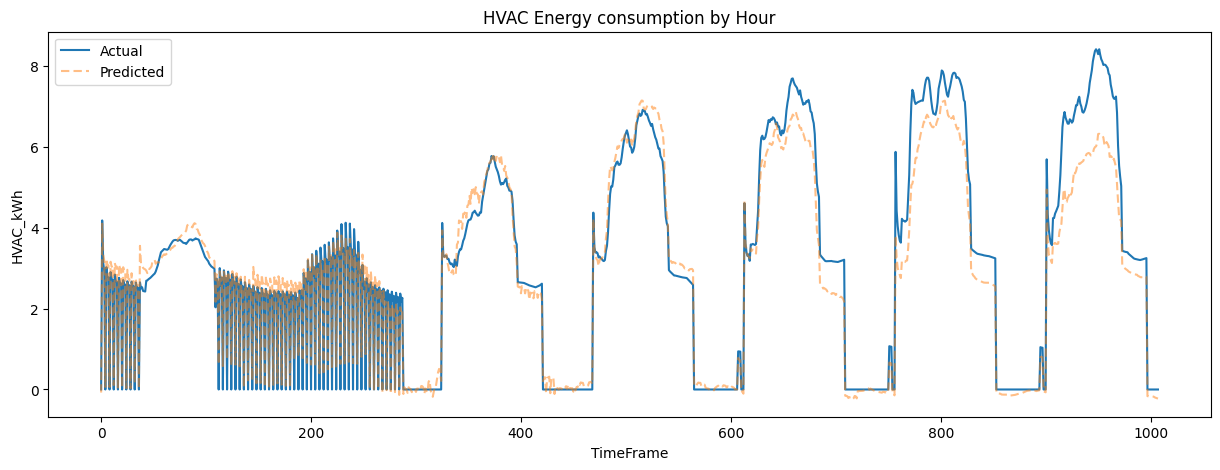

In [ ]:
plt.figure(figsize=(15, 5))
sns.lineplot(x=df.index, y=df['HVAC_kWh'], label='Actual')
sns.lineplot(x=pred.index, y=pred['Predicted_HVAC_kWh'], label='Predicted', dashes=(4,2), alpha=0.5)
plt.title('HVAC Energy consumption by Hour')
plt.xlabel('TimeFrame')
plt.legend()
plt.show()